## Setup

In [1]:
import sys
#!{sys.executable} -m pip3 install pandas numpy scikit-learn lightgbm matplotlib duckdb pyarrow seaborn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import duckdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, auc, roc_curve, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             precision_recall_curve, roc_auc_score, brier_score_loss)
from lightgbm import LGBMClassifier
import lightgbm as lgb
# install pyarrow to work with parquet files
import pyarrow.parquet as pq

#pd.set_option('display.max_rows', None)
random.seed(37)
np.random.seed(37)
warnings.filterwarnings("ignore")

con = duckdb.connect(database=":memory:")

print("Setup complete")

Setup complete


### Control panel- User Input required

Update root location, input filetype, site_name and confirm that race/ethnicity mapping correct. 

In [2]:
#Enter the location for your CLIF-1.0 directory
root_location = 'C:/Users/vchaudha/Downloads/concept-paper-v2'
# either parquet or csv only
filetype = 'csv'
site_name='RUSH'

race_map = {
    'White': 'White',
    'Black or African American': 'Black',
    'Asian': 'Asian',
    'Other': 'Others',
    'Unknown': 'Others',
    'Did Not Encounter': 'Others',
    'Refusal': 'Others',
    'American Indian or Alaska Native': 'Others',
    'Native Hawaiian or Other Pacific Islander': 'Others',
    np.nan: 'Others'
}

ethnicity_map = {
    'Not Hispanic or Latino': 'Not Hispanic or Latino',
    'Hispanic or Latino': 'Hispanic or Latino',
    'Did Not Encounter': 'Not Hispanic or Latino',
    'Refusal': 'Not Hispanic or Latino',
    '*Unspecified': 'Not Hispanic or Latino',
    np.nan: 'Not Hispanic or Latino'
}

finetune=True

In [3]:
adt_filepath = f"{root_location}/rclif/clif_adt.{filetype}"
encounter_filepath = f"{root_location}/rclif/clif_encounter_demographics_dispo_clean.{filetype}"
limited_filepath = f"{root_location}/rclif/clif_limited_identifiers.{filetype}"
demog_filepath = f"{root_location}/rclif/clif_patient_demographics.{filetype}"
vitals_filepath = f"{root_location}/rclif/clif_vitals_clean.{filetype}"
labs_filepath = f"{root_location}/rclif/clif_labs_clean.{filetype}"

## Import data

In [4]:
def read_data(filepath, filetype):
    """
    Read data from file based on file type.
    Parameters:
        filepath (str): Path to the file.
        filetype (str): Type of the file ('csv' or 'parquet').
    Returns:
        DataFrame: DataFrame containing the data.
    """
    if filetype == 'csv':
        return pd.read_csv(filepath)
    elif filetype == 'parquet':
        table = pq.read_table(filepath)
        return table.to_pandas()
    else:
        raise ValueError("Unsupported file type. Please provide either 'csv' or 'parquet'.")
    

def generate_facetgrid_histograms(data, category_column, value_column):
    """
    Generate histograms using seaborn's FacetGrid.

    Parameters:
        data (DataFrame): DataFrame containing the data.
        category_column (str): Name of the column containing categories.
        value_column (str): Name of the column containing values.

    Returns:
        FacetGrid: Seaborn FacetGrid object containing the generated histograms.
    """
    # Create a FacetGrid
    g = sns.FacetGrid(data, col=category_column, col_wrap=6, sharex=False, sharey=False)
    g.map(sns.histplot, value_column, bins=30, color='blue', edgecolor='black')

    # Set titles and labels
    g.set_titles('{col_name}')
    g.set_axis_labels(value_column, 'Frequency')

    # Adjust layout
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Histograms of {value_column} by {category_column}', fontsize=16)

    return g

def standardize_datetime(df):
    """
    Ensure that all *_dttm variables are in the correct format.
    Convert all datetime columns to a specific precision and remove timezone
    Parameters:
        DataFrame: DataFrame containing the data.
    Returns:
        DataFrame: DataFrame containing the data.
    """
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            # Here converting to 'datetime64[ns]' for uniformity and removing timezone with 'tz_convert(None)'
            df[col] = df[col].dt.tz_convert(None) if df[col].dt.tz is not None else df[col]
            # If you need to standardize to UTC and keep the timezone:
            # df[col] = df[col].dt.tz_localize('UTC') if df[col].dt.tz is None else df[col].dt.tz_convert('UTC')
    return df

def get_sql_import(filetype):
    if filetype == 'parquet':
        return 'read_parquet'
    if filetype == 'csv':
        return 'read_csv_auto'

sql_import = get_sql_import(filetype=filetype)

# create output directory
output_directory = os.path.join(os.getcwd(), 'output')
os.makedirs(output_directory, exist_ok=True)

In [5]:
location = read_data(adt_filepath, filetype)
encounter = read_data(encounter_filepath, filetype)
limited = read_data(limited_filepath, filetype)
demog = read_data(demog_filepath, filetype)

# Apply the standardization function to each DataFrame
location = standardize_datetime(location)
encounter = standardize_datetime(encounter)
limited = standardize_datetime(limited)
demog = standardize_datetime(demog)

### ICU close to Admission

1. Check ICU location_category between admission_dttmtime and 48hr stop from admission
2. Check ICU stay at least 24 hr (for ICU - OR - ICU including OR in ICU stay 24hr)

In [6]:
join=pd.merge(location[['encounter_id','location_category','in_dttm','out_dttm']],\
              limited[['encounter_id','admission_dttm']], on=['encounter_id'], how='left')

icu_data=pd.merge(join,\
                  encounter[['encounter_id','age_at_admission','disposition']], on=['encounter_id'], how='left')


icu_data['in_dttm'] = pd.to_datetime(icu_data['in_dttm'])
icu_data['admission_dttm'] = pd.to_datetime(icu_data['admission_dttm'])
icu_data['out_dttm'] = pd.to_datetime(icu_data['out_dttm'])
#icu_data['age_at_admission'] = icu_data['age_at_admission'].astype(int)

icu_48hr_check = icu_data[
    (icu_data['location_category'] == 'ICU') &
    (icu_data['in_dttm'] >= icu_data['admission_dttm']) &
    (icu_data['in_dttm'] <= icu_data['admission_dttm'] + pd.Timedelta(hours=48)) &
    (icu_data['admission_dttm'].dt.year >= 2020) & (icu_data['admission_dttm'].dt.year <= 2021) & 
    (icu_data['age_at_admission'] >= 18) & (icu_data['age_at_admission'].notna())
]['encounter_id'].unique()

icu_data=icu_data[icu_data['encounter_id'].isin(icu_48hr_check) & (icu_data['in_dttm'] <= icu_data['admission_dttm'] + pd.Timedelta(hours=72))].reset_index(drop=True)

icu_data = icu_data.sort_values(by=['in_dttm']).reset_index(drop=True)

icu_data["RANK"]=icu_data.sort_values(by=['in_dttm'], ascending=True).groupby("encounter_id")["in_dttm"].rank(method="first", ascending=True).astype(int)


min_icu=icu_data[icu_data['location_category'] == 'ICU'].groupby('encounter_id')['RANK'].min()
icu_data=pd.merge(icu_data, pd.DataFrame(zip(min_icu.index, min_icu.values), columns=['encounter_id', 'min_icu']), on='encounter_id', how='left')
icu_data=icu_data[icu_data['RANK']>=icu_data['min_icu']].reset_index(drop=True)

icu_data.loc[icu_data['location_category'] == 'OR', 'location_category'] = 'ICU'

icu_data['group_id'] = (icu_data.groupby('encounter_id')['location_category'].shift() != icu_data['location_category']).astype(int)
icu_data['group_id'] = icu_data.sort_values(by=['in_dttm'], ascending=True).groupby('encounter_id')['group_id'].cumsum()


icu_data = icu_data.sort_values(by=['in_dttm'], ascending=True).groupby(['encounter_id', 'location_category', 'group_id']).agg(
    min_in_dttm=('in_dttm', 'min'),
    max_out_dttm=('out_dttm', 'max'),
    admission_dttm=('admission_dttm', 'first'),
    age=('age_at_admission', 'first'),
    dispo=('disposition', 'first')
).reset_index()

min_icu=icu_data[icu_data['location_category'] == 'ICU'].groupby('encounter_id')['group_id'].min()
icu_data=pd.merge(icu_data, pd.DataFrame(zip(min_icu.index, min_icu.values), columns=['encounter_id', 'min_icu']), on='encounter_id', how='left')

icu_data=icu_data[(icu_data['min_icu']==icu_data['group_id']) &
         (icu_data['max_out_dttm']-icu_data['min_in_dttm'] >= pd.Timedelta(hours=24))
         ].reset_index(drop=True)


icu_data['after_24hr']=icu_data['min_in_dttm'] + pd.Timedelta(hours=24)

icu_data=icu_data[['encounter_id','min_in_dttm','max_out_dttm','after_24hr','age','dispo']]

icu_data=pd.merge(icu_data,\
                  demog, on=['encounter_id'], how='left')[['encounter_id','min_in_dttm','after_24hr','max_out_dttm','age','dispo','sex','ethnicity','race']]
icu_data=icu_data[~icu_data['sex'].isna()].reset_index(drop=True)
icu_data['isfemale']=(icu_data['sex'].str.lower() == 'female').astype(int)
icu_data['isdeathdispo'] = (icu_data['dispo'].str.contains('dead|expired|death|died', case=False, regex=True)).astype(int)

icu_data['ethnicity'] = icu_data['ethnicity'].map(ethnicity_map)
icu_data['race'] = icu_data['race'].map(race_map)
icu_data['ICU_stay_hrs']= (icu_data['max_out_dttm'] - icu_data['min_in_dttm']).dt.total_seconds() / 3600

del location,encounter,limited,demog

### Vitals

In [7]:
vitals = con.execute(f'''
    SELECT 
        encounter_id,
        CAST(recorded_dttm AS datetime) AS recorded_dttm,
        CAST(vital_value AS float) AS vital_value,
        vital_category 
    FROM 
        {sql_import}('{vitals_filepath}')
    WHERE 
        vital_category IN ('weight_kg', 'pulse', 'sbp', 'dbp', 'temp_c','height_inches') 
        AND encounter_id IN (SELECT DISTINCT encounter_id FROM icu_data);
''').df()

vitals=con.execute('''
PIVOT vitals
ON vital_category
USING first(vital_value)
GROUP BY encounter_id,recorded_dttm;
''').df()

vitals['height_meters'] = vitals['height_inches'] * 0.0254

# Calculate BMI
vitals['bmi'] = vitals['weight_kg'] / (vitals['height_meters'] ** 2)

In [8]:
icu_data_agg=pd.merge(icu_data,vitals, on=['encounter_id'], how='left')
icu_data_agg=icu_data_agg[(icu_data_agg['recorded_dttm'] >= icu_data_agg['min_in_dttm']) & (icu_data_agg['recorded_dttm'] <= icu_data_agg['after_24hr'])].reset_index(drop=True)

icu_data_agg = icu_data_agg.groupby(['encounter_id']).agg(
    min_bmi=('bmi', 'min'),
    max_bmi=('bmi', 'max'),
    avg_bmi=('bmi', 'mean'),
    min_weight_kg=('weight_kg', 'min'),
    max_weight_kg=('weight_kg', 'max'),
    avg_weight_kg=('weight_kg', 'mean'),
    min_pulse=('pulse', 'min'),
    max_pulse=('pulse', 'max'),
    avg_pulse=('pulse', 'mean'),
    min_sbp=('sbp', 'min'),
    max_sbp=('sbp', 'max'),
    avg_sbp=('sbp', 'mean'),
    min_dbp=('dbp', 'min'),
    max_dbp=('dbp', 'max'),
    avg_dbp=('dbp', 'mean'),
    min_temp_c=('temp_c', 'min'),
    max_temp_c=('temp_c', 'max'),
    avg_temp_c=('temp_c', 'mean'),
).reset_index()

icu_data=pd.merge(icu_data,icu_data_agg, on=['encounter_id'], how='left')

del vitals,icu_data_agg

### Labs

In [9]:
labs = con.execute(f'''
    SELECT 
        encounter_id,
        CAST(lab_order_dttm AS datetime) AS lab_order_dttm,
        TRY_CAST(lab_value AS float) AS lab_value,
        lab_category
    FROM 
         {sql_import}('{labs_filepath}')
    WHERE 
        ((lab_category='monocyte'               and lab_type_name='standard') OR
        (lab_category='lymphocyte'              and lab_type_name='standard') OR
        (lab_category='basophil'                and lab_type_name='standard') OR
        (lab_category='neutrophil'              and lab_type_name='standard') OR
        (lab_category='albumin'                 and lab_type_name='standard') OR
        (lab_category='ast'                     and lab_type_name='standard') OR
        (lab_category='total_protein'           and lab_type_name='standard') OR
        (lab_category='alkaline_phosphatase'    and lab_type_name='standard') OR
        (lab_category='bilirubin_total'         and lab_type_name='standard') OR
        (lab_category='bilirubin_conjugated'    and lab_type_name='standard') OR
        (lab_category='calcium'                 and lab_type_name='standard') OR
        (lab_category='chloride'                and lab_type_name='standard') OR
        (lab_category='potassium'               and lab_type_name='standard') OR
        (lab_category='sodium'                  and lab_type_name='standard') OR
        (lab_category='glucose_serum'           and lab_type_name='standard') OR
        (lab_category='hemoglobin'              and lab_type_name='standard') OR
        (lab_category='platelet count'          and lab_type_name='standard') OR
        (lab_category='wbc'                     and lab_type_name='standard'))
        AND encounter_id IN (SELECT DISTINCT encounter_id FROM icu_data);
''').df()

labs=con.execute('''
PIVOT labs
ON lab_category
USING first(lab_value)
GROUP BY encounter_id,lab_order_dttm;
''').df()

In [10]:
icu_data_agg=pd.merge(icu_data,labs, on=['encounter_id'], how='left')
icu_data_agg=icu_data_agg[(icu_data_agg['lab_order_dttm'] >= icu_data_agg['min_in_dttm']) & (icu_data_agg['lab_order_dttm'] <= icu_data_agg['after_24hr'])].reset_index(drop=True)


Lab_variables = [
   'albumin', 'alkaline_phosphatase',
       'ast', 'basophil', 'bilirubin_conjugated', 'bilirubin_total', 'calcium',
       'chloride', 'hemoglobin', 'lymphocyte', 'monocyte', 'glucose_serum', 
       'neutrophil', 'potassium', 'sodium', 'total_protein','platelet count', 
       'wbc'
]
agg_dict = {var: ['min', 'max', 'mean'] for var in Lab_variables}

icu_data_agg = icu_data_agg.groupby('encounter_id').agg(agg_dict).reset_index()

icu_data_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in icu_data_agg.columns.values]

icu_data=pd.merge(icu_data,icu_data_agg, on=['encounter_id'], how='left')

#### Model

In [11]:
model_col=['isfemale','age', 'min_bmi', 'max_bmi', 'avg_bmi',
       'min_weight_kg', 'max_weight_kg', 'avg_weight_kg', 'min_pulse',
       'max_pulse', 'avg_pulse', 'min_sbp', 'max_sbp', 'avg_sbp', 'min_dbp',
       'max_dbp', 'avg_dbp', 'min_temp_c', 'max_temp_c', 'avg_temp_c',
       'albumin_min', 'albumin_max', 'albumin_mean',
       'alkaline_phosphatase_min', 'alkaline_phosphatase_max',
       'alkaline_phosphatase_mean', 'ast_min', 'ast_max', 'ast_mean',
       'basophil_min', 'basophil_max', 'basophil_mean',
       'bilirubin_conjugated_min', 'bilirubin_conjugated_max',
       'bilirubin_conjugated_mean', 'bilirubin_total_min',
       'bilirubin_total_max', 'bilirubin_total_mean', 'calcium_min',
       'calcium_max', 'calcium_mean', 'chloride_min', 'chloride_max',
       'chloride_mean', 'glucose_serum_min', 'glucose_serum_max',
       'glucose_serum_mean', 'hemoglobin_min', 'hemoglobin_max',
       'hemoglobin_mean', 'lymphocyte_min', 'lymphocyte_max',
       'lymphocyte_mean', 'monocyte_min', 'monocyte_max', 'monocyte_mean',
       'neutrophil_min', 'neutrophil_max', 'neutrophil_mean',
       'platelet count_min', 'platelet count_max', 'platelet count_mean',
       'potassium_min', 'potassium_max', 'potassium_mean', 'sodium_min',
       'sodium_max', 'sodium_mean', 'total_protein_min', 'total_protein_max',
       'total_protein_mean', 'wbc_min', 'wbc_max', 'wbc_mean']

model=lgb.Booster(model_file=f'{root_location}/icu_mortality_model/models/lgbm_model_20240628-092136.txt')

### Feature distribution

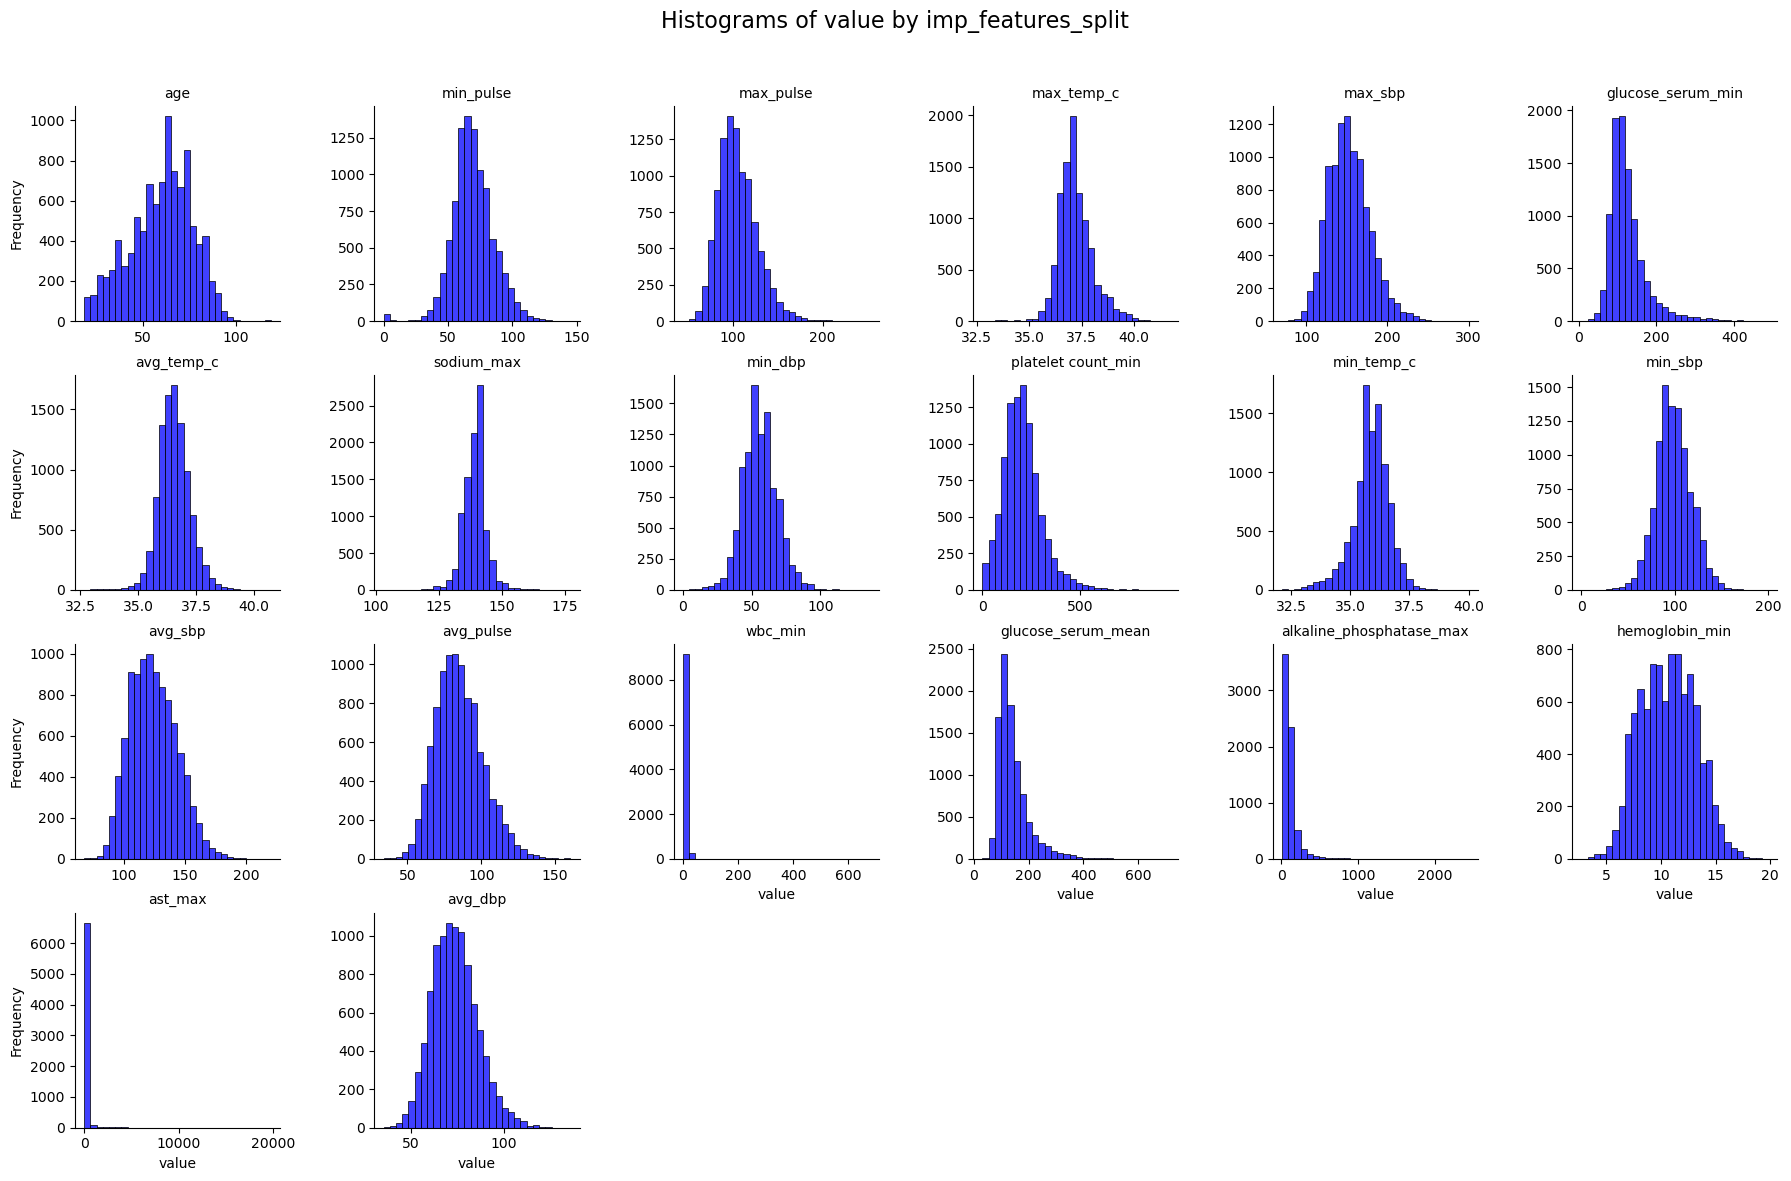

In [12]:
imp_features_split = [
    "age",
    "min_pulse",
    "max_pulse",
    "max_temp_c",
    "max_sbp",
    "glucose_serum_min",
    "avg_temp_c",
    "sodium_max",
    "min_dbp",
    "platelet count_min",
    "min_temp_c",
    "min_sbp",
    "avg_sbp",
    "avg_pulse",
    "wbc_min",
    "glucose_serum_mean",
    "alkaline_phosphatase_max",
    "hemoglobin_min",
    "ast_max",
    "avg_dbp"
]
data_unstack=icu_data[imp_features_split].unstack().reset_index(name='value').rename(columns={'level_0': 'imp_features_split', 'level_1': 'i'})
imp_plot = generate_facetgrid_histograms(data_unstack, 'imp_features_split', 'value')
plt.show(imp_plot)

icu_data[imp_features_split].describe().reset_index().rename(columns={'index': 'statistic'}).to_csv(f'{output_directory}/imp_features_split_stats_{site_name}.csv',index=False)
del data_unstack,imp_plot

In [13]:
icu_data[imp_features_split].describe().reset_index()

,index,age,min_pulse,max_pulse,max_temp_c,max_sbp,glucose_serum_min,avg_temp_c,sodium_max,min_dbp,...,min_temp_c,min_sbp,avg_sbp,avg_pulse,wbc_min,glucose_serum_mean,alkaline_phosphatase_max,hemoglobin_min,ast_max,avg_dbp
0,count,9906.000000,9903.000000,9903.000000,9836.000000,9846.000000,9563.000000,9836.000000,9587.000000,9846.000000,...,9836.000000,9846.000000,9846.000000,9903.000000,9454.000000,9563.000000,6919.000000,9456.000000,6919.000000,9846.000000
1,mean,59.604078,69.417244,105.522873,37.215286,152.535339,124.989128,36.546371,139.035889,55.636604,...,35.857475,98.355782,124.093857,85.045746,10.202900,142.095627,117.253647,10.635195,186.836395,73.466370
2,std,16.856101,16.062170,21.469734,0.830138,25.817413,48.649761,0.684210,4.741272,12.618855,...,0.769454,19.023323,19.069269,16.159632,11.353358,59.251919,121.253517,2.504240,1043.571777,12.341998
3,min,18.000000,0.000000,45.000000,32.777779,70.000000,7.000000,32.672836,103.000000,0.000000,...,32.111115,0.000000,67.250000,33.913044,0.030000,31.000000,9.000000,2.700000,3.000000,35.000000
4,25%,48.000000,59.000000,91.000000,36.666668,134.000000,95.000000,36.111111,137.000000,47.000000,...,35.500000,86.000000,109.454544,73.500000,6.400000,103.500000,66.000000,8.700000,20.000000,64.721817
5,50%,62.000000,68.000000,103.000000,37.111115,151.000000,114.000000,36.509258,139.000000,55.000000,...,35.888889,97.000000,122.634842,83.629631,8.770000,126.250000,87.000000,10.600000,31.000000,72.739929
6,75%,72.000000,79.000000,118.000000,37.666668,168.000000,141.000000,36.944447,141.000000,63.000000,...,36.333336,110.000000,137.333328,94.972794,12.280000,163.000000,124.000000,12.500000,59.000000,81.145470
7,max,119.000000,145.000000,252.000000,41.666668,300.000000,487.000000,40.722221,177.000000,136.000000,...,40.000000,200.000000,220.451614,160.137924,676.940002,714.000000,2437.000000,19.799999,19736.000000,136.000000


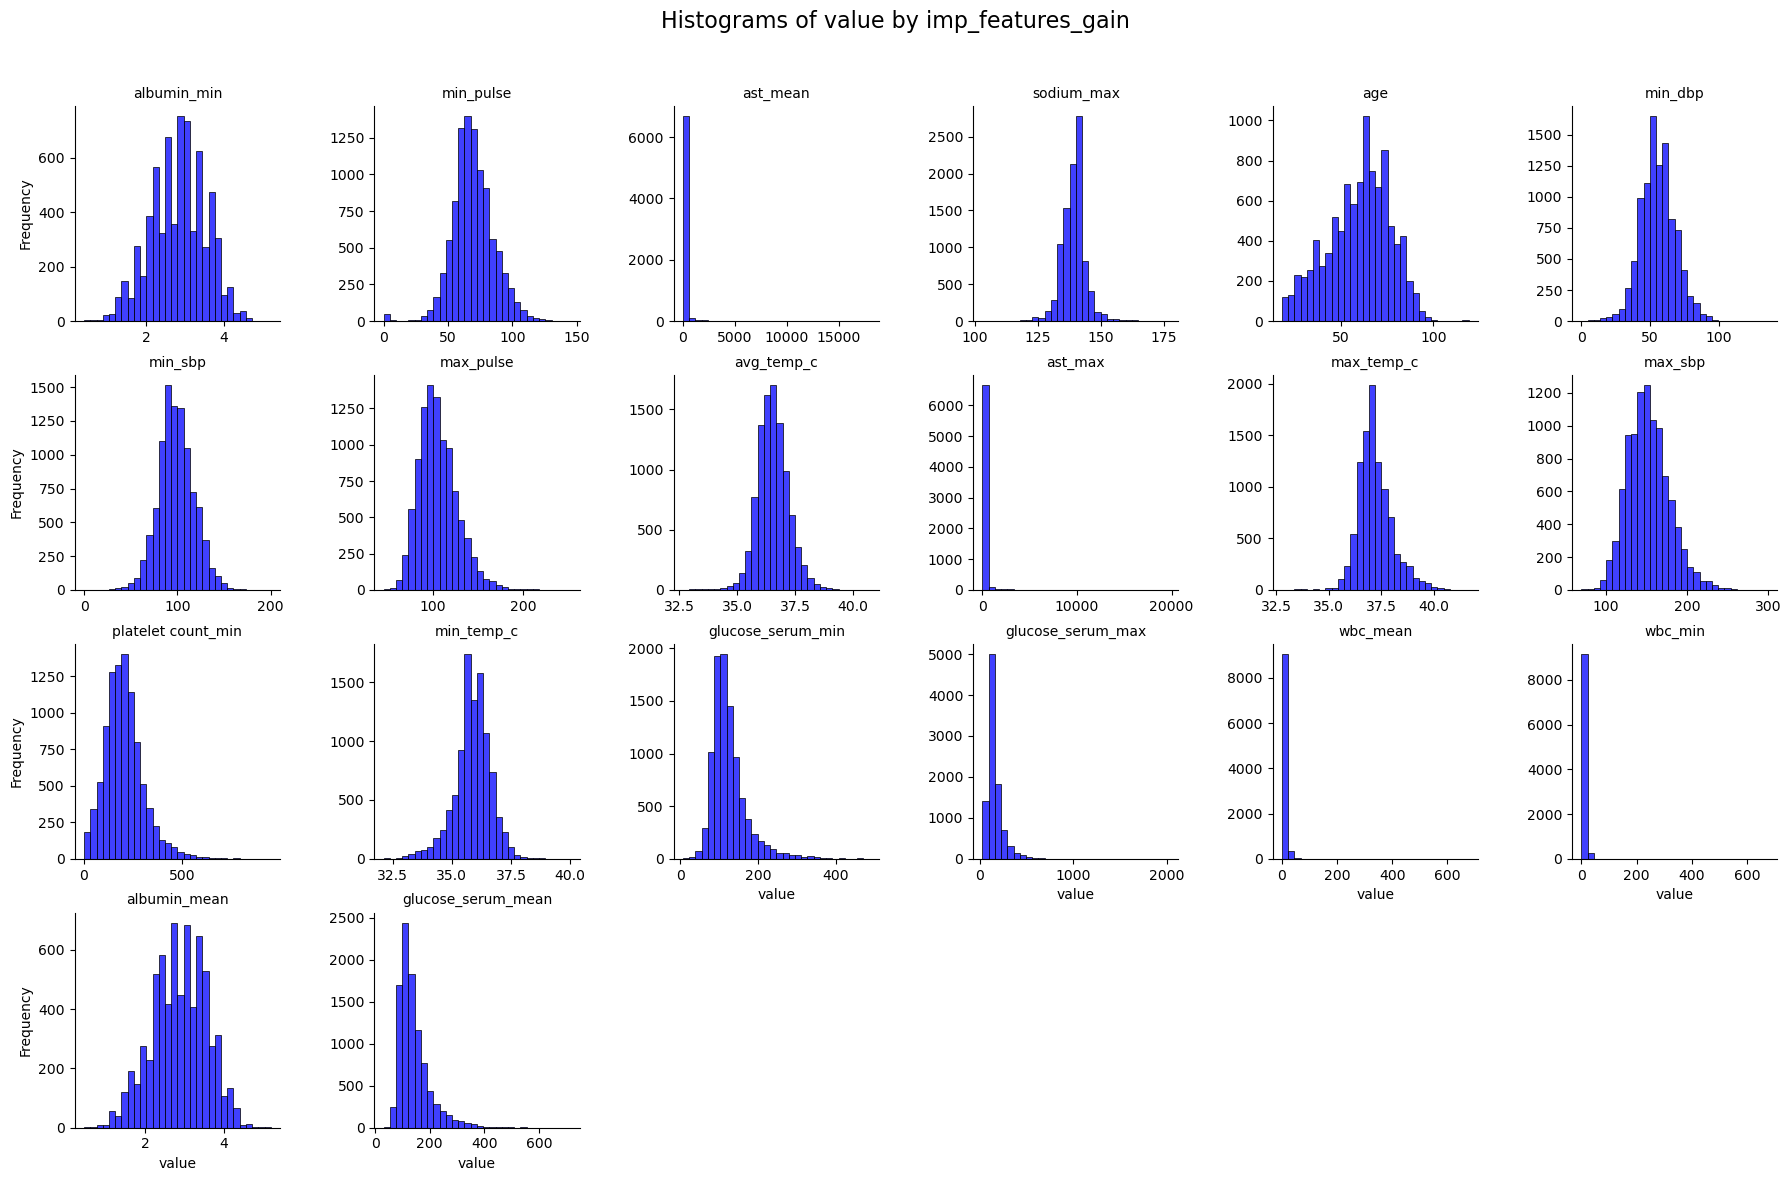

In [14]:
imp_features_gain=['albumin_min',
 'min_pulse',
 'ast_mean',
 'sodium_max',
 'age',
 'min_dbp',
 'min_sbp',
 'max_pulse',
 'avg_temp_c',
 'ast_max',
 'max_temp_c',
 'max_sbp',
 'platelet count_min',
 'min_temp_c',
 'glucose_serum_min',
 'glucose_serum_max',
 'wbc_mean',
 'wbc_min',
 'albumin_mean',
 'glucose_serum_mean']
data_unstack=icu_data[imp_features_gain].unstack().reset_index(name='value').rename(columns={'level_0': 'imp_features_gain', 'level_1': 'i'})
imp_plot = generate_facetgrid_histograms(data_unstack, 'imp_features_gain', 'value')
plt.show(imp_plot)

icu_data[imp_features_gain].describe().reset_index().rename(columns={'index': 'statistic'}).to_csv(f'{output_directory}/imp_features_gain_stats_{site_name}.csv',index=False)
del data_unstack,imp_plot

### Metrics

In [25]:
X_test=icu_data[model_col]
y_test=icu_data['isdeathdispo']

y_pred_proba = model.predict(X_test)
icu_data['pred_proba'] = y_pred_proba

thr=0.208
n_bootstraps = 1000
rng_seed = 42  

def bootstrap_metric(metric_func, y_test, y_pred_proba, thr, n_bootstraps, rng_seed):
    rng = np.random.RandomState(rng_seed)
    bootstrapped_scores = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred_proba), len(y_pred_proba))
        if metric_func == roc_auc_score:
            score = metric_func(y_test[indices], y_pred_proba[indices])
        else:
            y_pred_binary = (y_pred_proba >= thr).astype(int)
            score = metric_func(y_test[indices], y_pred_binary[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    

    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    return confidence_lower, confidence_upper


accuracy = accuracy_score(y_test, (y_pred_proba >= thr).astype(int))
recall = recall_score(y_test, (y_pred_proba >= thr).astype(int))
precision = precision_score(y_test, (y_pred_proba >= thr).astype(int))
roc_auc = roc_auc_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)

accuracy_ci = bootstrap_metric(accuracy_score, y_test, y_pred_proba, thr, n_bootstraps, rng_seed)
recall_ci = bootstrap_metric(recall_score, y_test, y_pred_proba, thr, n_bootstraps, rng_seed)
precision_ci = bootstrap_metric(precision_score, y_test, y_pred_proba, thr, n_bootstraps, rng_seed)
roc_auc_ci = bootstrap_metric(roc_auc_score, y_test, y_pred_proba, thr, n_bootstraps, rng_seed)
brier_score_ci = bootstrap_metric(brier_score_loss, y_test, y_pred_proba, thr, n_bootstraps, rng_seed)

results_Metric = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'ROC AUC', 'Brier Score Loss'],
    'Value': [accuracy, recall, precision, roc_auc, brier_score],
    'CI Lower': [accuracy_ci[0], recall_ci[0], precision_ci[0], roc_auc_ci[0], brier_score_ci[0]],
    'CI Upper': [accuracy_ci[1], recall_ci[1], precision_ci[1], roc_auc_ci[1], brier_score_ci[1]],
    'SiteName': [site_name] * 5
})

results_Metric.to_csv(f'{output_directory}/result_metrics_2_{site_name}.csv', index=False)


results_Metric

,Metric,Value,CI Lower,CI Upper,SiteName
0,Accuracy,0.906420,0.900565,0.912174,RUSH
1,Recall,0.319178,0.284197,0.354749,RUSH
2,Precision,0.351433,0.312883,0.388186,RUSH
3,ROC AUC,0.810183,0.794502,0.825573,RUSH
4,Brier Score Loss,0.059596,0.087826,0.099435,RUSH


#### probablity table

In [16]:
prob_df_lgbm = pd.DataFrame({'site_label ':y_test, 'site_proba': y_pred_proba,'Site_name':f"{site_name}" })
#prob_df_lgbm.to_csv(f'{output_directory}/Model_probabilities_{site_name}.csv',index=False)
prob_df_lgbm.head()
#do not share this file

,site_label,site_proba,Site_name
0,0,0.096085,RUSH
1,0,0.012856,RUSH
2,0,0.017285,RUSH
3,0,0.008445,RUSH
4,0,0.018557,RUSH


### Model fairness test accross 'race', 'ethnicity', 'sex'

In [17]:
def calculate_metrics(data, true_col, pred_prob_col, subgroup_cols, thr=0.208):
    results = []
    total_count = len(data)

    for subgroup_col in subgroup_cols:
        filtered_data = data.dropna(subset=[subgroup_col])
        
        for group in filtered_data[subgroup_col].unique():
            subgroup_data = filtered_data[filtered_data[subgroup_col] == group]
            group_count = len(subgroup_data)
            proportion = group_count / total_count

            if np.unique(subgroup_data[true_col]).size > 1:  # Check if both classes are present
                auc = roc_auc_score(subgroup_data[true_col], subgroup_data[pred_prob_col])
                tn, fp, fn, tp = confusion_matrix(subgroup_data[true_col], (subgroup_data[pred_prob_col] > thr).astype(int)).ravel()
                ppv = tp / (tp + fp) if (tp + fp) != 0 else 0
                sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
                npv = tn / (tn + fn) if (tn + fn) != 0 else 0
                recall = sensitivity
                acc = (tp + tn) / (tp + fn + tn + fp) if (tp + fn + tn + fp) != 0 else 0

                result = {
                    'Subgroup': subgroup_col, 
                    'Group': group,
                    'TN': tn,
                    'TP': tp,
                    'FP' :fp,
                    'FN': fn,
                    'AUC': auc, 
                    'PPV': ppv, 
                    'Sensitivity': sensitivity, 
                    'Specificity': specificity, 
                    'NPV': npv, 
                    'Recall': recall, 
                    'Accuracy': acc, 
                    'brier_score': brier_score_loss(subgroup_data[true_col], subgroup_data[pred_prob_col]),
                    'Group Count': group_count, 
                    'Total Count': total_count, 
                    'Proportion': proportion,
                    'site_name': f'{site_name}'
                }
            else:
                result = {
                    'Subgroup': subgroup_col, 
                    'Group': group, 
                     'TN': tn,
                    'TP': tp,
                    'FP' :fp,
                    'FN': fn,
                    'AUC': 'Not defined', 
                    'PPV': 'Not applicable', 
                    'Sensitivity': 'Not applicable', 
                    'Specificity': 'Not applicable', 
                    'NPV': 'Not applicable', 
                    'Recall': 'Not applicable', 
                    'Accuracy': 'Not applicable', 
                    'brier_score': 'Not applicable', 
                    'Group Count': group_count, 
                    'Total Count': total_count, 
                    'Proportion': proportion,
                    'site_name': f'{site_name}'
                }
            
            results.append(result)
    
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
result_df = calculate_metrics(icu_data, 'isdeathdispo', 'pred_proba', ['race', 'ethnicity', 'sex'])

In [18]:
result_df.to_csv(f'{output_directory}/fairness_test_{site_name}.csv',index=False)
result_df

,Subgroup,Group,TN,TP,FP,FN,AUC,PPV,Sensitivity,Specificity,NPV,Recall,Accuracy,brier_score,Group Count,Total Count,Proportion,site_name
0,race,White,3325,80,143,170,0.816382,0.358744,0.320000,0.958766,0.951359,0.320000,0.915815,0.054578,3718,9906,0.375328,RUSH
1,race,Others,1585,45,78,138,0.772516,0.365854,0.245902,0.953097,0.919907,0.245902,0.882990,0.082299,1846,9906,0.186352,RUSH
2,race,Black,3554,98,188,173,0.825459,0.342657,0.361624,0.949759,0.953582,0.361624,0.910042,0.053130,4013,9906,0.405108,RUSH
3,race,Asian,282,10,21,16,0.805661,0.322581,0.384615,0.930693,0.946309,0.384615,0.887538,0.067789,329,9906,0.033212,RUSH
4,ethnicity,Not Hispanic or Latino,7014,189,364,358,0.821675,0.341772,0.345521,0.950664,0.951438,0.345521,0.908896,0.055604,7925,9906,0.800020,RUSH
5,ethnicity,Hispanic or Latino,1732,44,66,139,0.771632,0.400000,0.240437,0.963293,0.925708,0.240437,0.896517,0.075565,1981,9906,0.199980,RUSH
6,sex,Male,4597,124,212,286,0.816791,0.369048,0.302439,0.955916,0.941429,0.302439,0.904579,0.063316,5219,9906,0.526852,RUSH
7,sex,Female,4149,109,218,211,0.802747,0.333333,0.340625,0.950080,0.951606,0.340625,0.908470,0.055454,4687,9906,0.473148,RUSH


#### Site Thr Analysis

In [19]:
def top_n_percentile(target_var, pred_proba):
    #thr_list = [0.99,0.97, 0.95,0.90,0.80,0.70,0.60,0.50,0.40,0.30,0.20,0.10]
    thr_list = np.arange(1, 0, -0.01)
    col = ['N Percentile', 'Thr Value','TN','FP','FN','TP','Sensitivity','Specificity','PPV', 'NPV' ,'Recall','Accuracy','site_name']
    result = pd.DataFrame(columns = col)
    i = 0
    
    for thr in thr_list: 
        prob = pd.DataFrame()
        prob['target_var'] = target_var
        prob['pred_proba'] = pred_proba

        thr_value = prob['pred_proba'].quantile(thr)
        prob['pred_proba_bin'] = np.where(prob['pred_proba'] >= thr_value, 1, 0)
        tn,fp,fn,tp = confusion_matrix(prob['target_var'], prob['pred_proba_bin']).ravel()

        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        ppv = tp/(tp+fp)
        npv = tn/(tn+fn)
        recall = tp/(tp+fn)
        acc = (tp+tn)/(tp+fn+tn+fp)
        n_prec = 'Top '+ str(np.round((1 - thr) * 100,0))+ "%"
        result.loc[i] = [n_prec,thr_value,tn,fp,fn,tp,sensitivity,specificity ,ppv,npv, recall, acc,f'{site_name}']
        i+=1
    return result
topn=top_n_percentile(y_test,y_pred_proba)

In [20]:
topn.to_csv(f'{output_directory}/Top_N_percentile_PPV_{site_name}.csv',index=False)
topn.head(6)

,N Percentile,Thr Value,TN,FP,FN,TP,Sensitivity,Specificity,PPV,NPV,Recall,Accuracy,site_name
0,Top 0.0%,0.970428,9176,0,729,1,0.001370,1.000000,1.000000,0.926401,0.001370,0.926408,RUSH
1,Top 1.0%,0.615274,9141,35,665,65,0.089041,0.996186,0.650000,0.932184,0.089041,0.929336,RUSH
2,Top 2.0%,0.481072,9080,96,627,103,0.141096,0.989538,0.517588,0.935407,0.141096,0.927014,RUSH
3,Top 3.0%,0.390897,9021,155,587,143,0.195890,0.983108,0.479866,0.938905,0.195890,0.925096,RUSH
4,Top 4.0%,0.325992,8951,225,558,172,0.235616,0.975480,0.433249,0.941319,0.235616,0.920957,RUSH
5,Top 5.0%,0.269445,8876,300,534,196,0.268493,0.967306,0.395161,0.943252,0.268493,0.915809,RUSH


### RUSH THR Top N

In [21]:
col = ['Thr Value','TN','FP','FN','TP','Sensitivity','Specificity','PPV', 'NPV' ,'Recall','Accuracy','site_name']
result = pd.DataFrame(columns = col)

prob = pd.DataFrame()
prob['target_var'] = y_test
prob['pred_proba'] = y_pred_proba

prob['pred_proba_bin'] = np.where(prob['pred_proba'] >= thr, 1, 0)
tn,fp,fn,tp = confusion_matrix(prob['target_var'], prob['pred_proba_bin']).ravel()

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
recall = tp/(tp+fn)
acc = (tp+tn)/(tp+fn+tn+fp)
n_prec = 'Top '+ str((1 - thr))+ "%"
result.loc[0] = [thr,tn,fp,fn,tp,sensitivity,specificity ,ppv,npv, recall, acc,f'{site_name}']

result.to_csv(f'{output_directory}/Top_N_percentile_atRushThr_{site_name}.csv',index=False)
result

,Thr Value,TN,FP,FN,TP,Sensitivity,Specificity,PPV,NPV,Recall,Accuracy,site_name
0,0.208,8746,430,497,233,0.319178,0.953139,0.351433,0.94623,0.319178,0.90642,RUSH


### Calibration plot

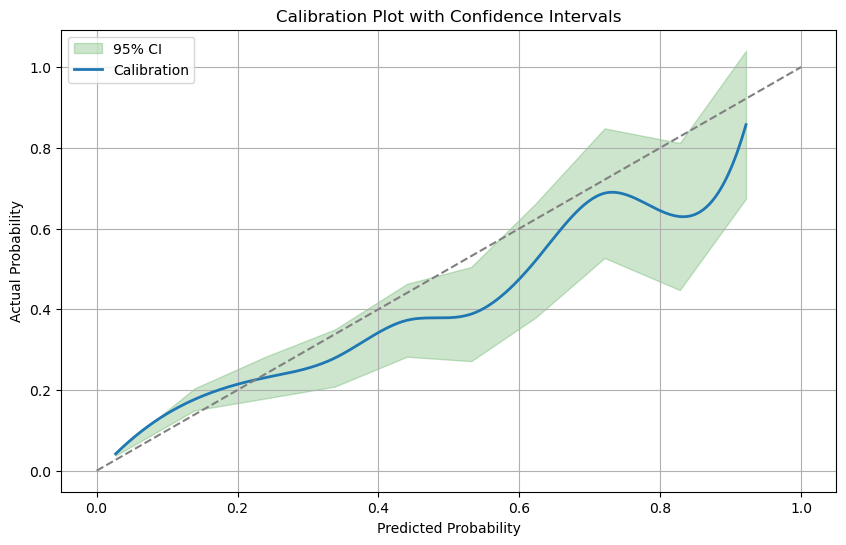

In [22]:
from scipy.interpolate import make_interp_spline
def create_calibration_data(y_test, y_pred_proba, n_bins=10):
    # Create a DataFrame
    df = pd.DataFrame({'y_test': y_test, 'y_pred_proba': y_pred_proba})
    
    # Create bins
    df['bin'] = pd.cut(df['y_pred_proba'], bins=n_bins, labels=False, include_lowest=True)
    
    # Calculate mean predicted probability and actual probability in each bin
    calibration_data = df.groupby('bin').agg(
        predicted_prob=('y_pred_proba', 'mean'),
        actual_prob=('y_test', 'mean'),
        n=('y_test', 'size')
    ).reset_index()
    
    # Calculate standard error and confidence intervals
    calibration_data['se'] = np.sqrt((calibration_data['actual_prob'] * (1 - calibration_data['actual_prob'])) / calibration_data['n'])
    calibration_data['lower_ci'] = calibration_data['actual_prob'] - 1.96 * calibration_data['se']
    calibration_data['upper_ci'] = calibration_data['actual_prob'] + 1.96 * calibration_data['se']
    calibration_data['site']= site_name
    
    return calibration_data



# Create calibration data with confidence intervals
calibration_data = create_calibration_data(y_test, y_pred_proba)

# Write the calibration data to a CSV file
calibration_data.to_csv(f"output/calibration_data_{site_name}.csv", index=False)



# Smooth the line using spline interpolation
x_new = np.linspace(calibration_data['predicted_prob'].min(), calibration_data['predicted_prob'].max(), 300)
spl = make_interp_spline(calibration_data['predicted_prob'], calibration_data['actual_prob'], k=3)
y_smooth = spl(x_new)


# Plot calibration plot with shaded confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(calibration_data['predicted_prob'], 
                 calibration_data['lower_ci'], 
                 calibration_data['upper_ci'], 
                 color='green', alpha=0.2, label='95% CI')
plt.plot(x_new, y_smooth, label='Calibration', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Calibration Plot with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
calibration_data

,bin,predicted_prob,actual_prob,n,se,lower_ci,upper_ci,site
0,0,0.026994,0.041677,8446,0.002175,0.037414,0.045939,RUSH
1,1,0.139165,0.176862,752,0.013914,0.149591,0.204133,RUSH
2,2,0.239169,0.230469,256,0.026321,0.178880,0.282058,RUSH
3,3,0.338151,0.279221,154,0.036151,0.208366,0.350076,RUSH
4,4,0.440635,0.372727,110,0.046103,0.282366,0.463089,RUSH
5,5,0.531629,0.388060,67,0.059534,0.271373,0.504747,RUSH
6,6,0.623219,0.520833,48,0.072106,0.379505,0.662161,RUSH
7,7,0.720948,0.687500,32,0.081938,0.526901,0.848099,RUSH
8,8,0.827765,0.629630,27,0.092935,0.447477,0.811782,RUSH
9,9,0.921692,0.857143,14,0.093522,0.673840,1.040446,RUSH


### AUC & PR Curve

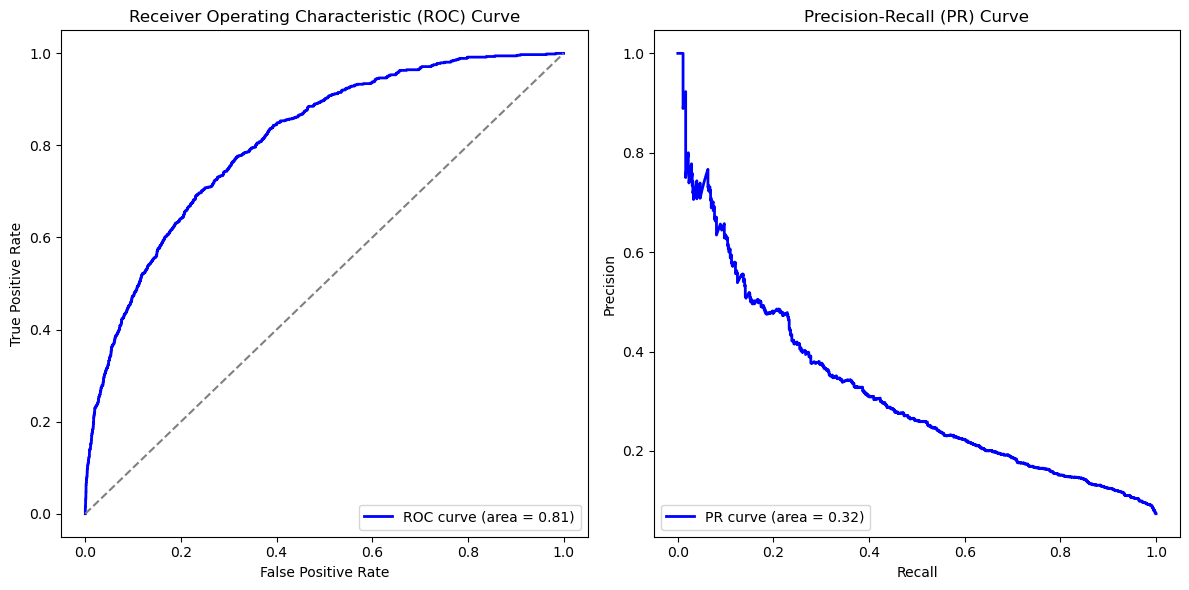

In [24]:
# Compute ROC curve and AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Ensure all arrays have the same length by matching dimensions correctly
if len(fpr) != len(roc_thresholds):
    roc_thresholds = np.append(roc_thresholds, 1)

# Save values to CSV
roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'roc_thresholds': roc_thresholds,'site':site_name})
pr_data = pd.DataFrame({'precision': precision, 'recall': recall, 'pr_thresholds': np.append(pr_thresholds, 1),'site':site_name})

roc_data.to_csv(f'output/roc_curve_data_{site_name}.csv', index=False)
pr_data.to_csv(f'output/pr_curve_data_{site_name}.csv', index=False)

# Plot ROC curve and PR curve in one image
plt.figure(figsize=(12, 6))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot PR curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()